In [2]:
# General Imports
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from mpl_toolkits.mplot3d import Axes3D

# General sklearn imports
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, classification_report

# Sklearn imports for Models
from sklearn.svm import SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier

# ADVICE
# Use AWS & sagemaker till Rice platform !!
# Change to classification task !!!
# Down sample: randomly sample 0 to make equal size for both classes !!!
# Increase class 1 information **
# Impute might affect data. Check if distribution has not changed for the other features. !!
# Find features with difference e.g. t-test (normal), non-parametric (Mann-Whitney, Wilcoxon?) 

XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/therafu/venv/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/therafu/venv/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


# Data Preprocessing

1. The given features are identical to a variable not given below.
    
    f34, f35, f37, f38, f58, f86, f87, f88, f96, f97, f98, f106, f107, f108, f116, f117, f118, f126, f127, f128, f155, f156, f157, f165, f166, f167, f175, f176, f177, f185, f186, f187, f195, f196, f197, f225, f226, f227, f235, f236, f237, f245, f246, f247, f255, f256, f257, f265, f266, f267, f294, f295, f296, f302, f303, f304, f310, f311, f312, f318, f319, f320, f326, f327, f328, f345, f354, f362, f371, f379, f408, f417, f427, f457, f478, f488, f498, f508, f553, f563, f573, f582, f599, f700, f701, f702, f729, f741, f764
    
    Add f678 if imputed before dropping
    
   

In [51]:
duplicate_columns = ['f34', 'f35', 'f37', 'f38', 'f58', 'f86', 'f87', 'f88', 'f96', 'f97', 
                     'f98', 'f106', 'f107', 'f108', 'f116', 'f117', 'f118', 'f126', 'f127',
                     'f128', 'f155', 'f156', 'f157', 'f165', 'f166', 'f167', 'f175', 'f176',
                     'f177', 'f185', 'f186', 'f187', 'f195', 'f196', 'f197', 'f225', 'f226',
                     'f227', 'f235', 'f236', 'f237', 'f245', 'f246', 'f247', 'f255', 'f256',
                     'f257', 'f265', 'f266', 'f267', 'f294', 'f295', 'f296', 'f302', 'f303',
                     'f304', 'f310', 'f311', 'f312', 'f318', 'f319', 'f320', 'f326', 'f327',
                     'f328', 'f345', 'f354', 'f362', 'f371', 'f379', 'f408', 'f417', 'f427',
                     'f457', 'f478', 'f488', 'f498', 'f508', 'f553', 'f563', 'f573', 'f582',
                     'f599', 'f700', 'f701', 'f702', 'f729', 'f741', 'f764']

skewed = ['f72', 'f132', 'f133', 'f134', 'f136', 'f137', 'f138', 'f139', 'f201', 'f202', 
          'f203', 'f205', 'f206', 'f207', 'f271', 'f272', 'f273', 'f275', 'f276', 'f277', 
          'f286', 'f287', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 
          'f350', 'f358', 'f367', 'f375', 'f393', 'f394', 'f414', 'f415', 'f418', 'f419', 
          'f420', 'f421', 'f429', 'f430', 'f451', 'f466', 'f469', 'f471', 'f472', 'f515', 
          'f525', 'f534', 'f536', 'f537', 'f586', 'f587', 'f588', 'f591', 'f592', 'f594', 
          'f595', 'f604', 'f612', 'f615', 'f616', 'f617', 'f618', 'f619', 'f634', 'f635', 
          'f636', 'f637', 'f648', 'f649', 'f650', 'f651', 'f673', 'f699', 'f723', 'f724']

def read_data(csv_path):
    """
    Given a path to a file, reads in the data in the file
    """
    print("Reading Data...")
    data = pd.read_csv(csv_path)
    print("Shape:", data.shape)
    return data

def clean_data(data):
    """
    Cleans data by taking string based NAs and converting to NaN.
    Assumes that the string columns are integer columns.
    """
    print("Cleaning Data...")
    data.drop(columns=["id"], inplace=True)
    data = data.replace("NA", None)
    for col_name in data.select_dtypes(exclude=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns:
        data[col_name] = pd.to_numeric(data[col_name], downcast="integer", errors="coerce")
    return data

def drop_duplicate_columns(data):
    """
    Iterates through columns in dataframe to find columns
    with identical values and compiles a single one of these columns into
    a set of columns to be dropped.
    """
    print("Drop Duplicate Columns in Data...")
    col_names = set() 
    for x in range(data.shape[1]):
        if (x%5 == 0):
            print(x, "...")
        col = data.iloc[:, x] 
        for y in range(x + 1, data.shape[1]):
            check_dup = data.iloc[:, y] 
            if col.equals(check_dup): 
                col_names.add(data.columns.values[y]) 
    return data.drop(columns=list(col_names))

def direct_drop_duplicates(data):
    """
    Iterates through columns in dataframe to find columns
    with identical values and compiles a single one of these columns into
    a set of columns to be dropped.
    """
    print("Directly Dropping Duplicate Columns...")
    dropped_data = data.drop(columns=duplicate_columns)
    return dropped_data

def impute_values(data):
    """
    Fits a simple imputer to the dataset and imputes missing
    values in the dataset.
    Might need to be changed to an iterative imputer.
    """
    print("Imputing Missing Data...")
    matrix = data.to_numpy()
    imp = SimpleImputer()
    imp.fit(matrix)
    complete_data = pd.DataFrame(imp.transform(matrix), columns=data.columns)
    return complete_data

def log_skew(data):
    """
    Takes the log of the values of columns with data that is
    skewed greater than 10 standard deviations
    """
    print("Log Skewed Data...")
    data_copy = data.copy()
    for col in data_copy.columns:
        std = data[col].std()
        a = (data[col] - data[col].mean())/std
        skewval = skew(a)
        if abs(skewval) > 10:
            data_copy[col] = np.log(data_copy[col]+1.0000001 - data_copy[col].min())
    return data_copy

def direct_log_skew(data):
    """
    Takes the log of the values of columns with data that is
    skewed greater than 10 standard deviations
    """
    print("Directly Log Skewed Data...")
    data_copy = data.copy()
    for col in skewed:
        print(col, data_copy[col].min())
        data_copy[col] = np.log(data_copy[col] + 1.0000001 - data_copy[col].min())
    return data_copy

def reduce_memory_usage(data):
    """
    Iterates over all the columns in data and checks
    the minimum and maximum values to map the data
    to a lower memory type.
    Mutates input.
    """
    print("Reducing Memory Data...")
    count = 0
    for col_name in data.columns:
        if col_name == "loss":
            continue
        if count % 50 == 0:
            print(count)
        count +=1
        col = data[col_name]
        sum_val = col.sum()
        max_val = col.max()
        min_val = col.min()
        int_sum_val = col.astype('int').sum()
        if int_sum_val != sum_val:
            if max_val <= 127 and min_val >= -128: 
                data[col_name] = col.astype("int8")
                continue
            if max_val <= 32767 and min_val >= -32768:
                data[col_name] = col.astype("int16")
                continue
            if max_val <= 2147483647 and min_val >= -2147483648:
                data[col_name] = col.astype("int32")
                continue
            if max_val <= 9223372036854775807 and min_val >= -9223372036854775808:
                data[col_name] = col.astype("int64")
                continue
        else:
            if max_val <= np.finfo(np.float16).max and min_val >= np.finfo(np.float16).min:
                data[col_name] = col.astype("float16")
                continue
            if max_val <= np.finfo(np.float32).max and min_val >= np.finfo(np.float32).min:
                data[col_name] = col.astype("float32")
                continue
            if max_val <= np.finfo(np.float64).max and min_val >= np.finfo(np.float64).min:
                data[col_name] = col.astype("float64")
                continue

In [52]:
data = clean_data(read_data("train_v2.csv"))
complete_loan_data = impute_values(data)
dropped_data = direct_drop_duplicates(complete_loan_data)
final_data = direct_log_skew(dropped_data)
# reduce_memory_usage(final_data)

Directly Log Skewed Data...
f72 -1.0
f132 0.0
f133 0.0
f134 0.0
f136 0.0
f137 0.0
f138 0.0
f139 0.0
f201 0.0
f202 0.0
f203 0.0
f205 0.0
f206 0.0
f207 0.0
f271 0.0
f272 0.0
f273 0.0
f275 0.0
f276 0.0
f277 0.0
f286 2.0
f287 2.0
f332 0.0
f333 0.0
f334 0.0
f335 0.0
f336 0.0
f337 0.0
f338 0.0
f339 0.0
f350 -15.41779
f358 -27.182109999999998
f367 -51.27608
f375 -53.2344
f393 -913.76
f394 -14612.92
f414 0.0
f415 0.0
f418 0.0
f419 0.0
f420 0.0
f421 0.0
f429 2.0
f430 2.0
f451 -100.2025
f466 0.0
f469 0.0
f471 1.0
f472 0.0
f515 0.0
f525 -32.1152
f534 0.0
f536 1.0
f537 0.0
f586 -1.0
f587 -1.0
f588 -1.0
f591 0.0
f592 0.0
f594 0.0
f595 0.0
f604 0.0
f612 -50.530976
f615 -0.06
f616 -1.0
f617 -0.13
f618 0.0
f619 0.0
f634 0.0
f635 0.0
f636 0.0
f637 0.0
f648 -1.0
f649 -1.0
f650 -1.0
f651 -1.0
f673 -1.0
f699 0.0
f723 0.0
f724 0.0


In [4]:
# Check memory changes
print(data.info())
print(complete_loan_data.info())
print(dropped_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 770 entries, f1 to loss
dtypes: float64(672), int64(98)
memory usage: 619.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 770 entries, f1 to loss
dtypes: float16(75), float32(21), float64(21), int16(186), int32(81), int64(51), int8(335)
memory usage: 185.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 681 entries, f1 to loss
dtypes: float16(40), float32(21), float64(21), int16(132), int32(81), int64(51), int8(335)
memory usage: 167.3 MB
None


# Data Exploration

1. The target variable is imbalanced. See Graph 1.


2. The following features are perfectly correlated by Pearson correlation.

    f74  - f722; f676 - f765
    
    
3. There is no one feature that has a high correlation with the target variable under Pearson's correlation. The feature with the highest correlation has a score of 0.03985.


4. Under Spearman's correlation, the highest correlation with the target variable is ~0.11.
    
    
5. Some features are perfectly correlated under Pearson. See heatmap at Graph 2. Spearman is still being explored.

    
6. The features are not linearly separable as can be seen in Graphs 3 & 4. The yellow and light blue signify the positive class. One future exploration would be to consider breaking the classes at 0.5 instead of 0.

7. Tranform skewed features using log to make them more gaussian. !!!

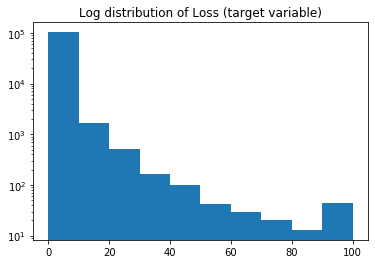

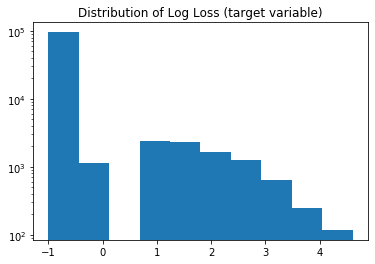

In [56]:
# Plot the target variable

plt.hist(final_data["loss"])
plt.yscale('log')
plt.title('Log distribution of Loss (target variable)')
plt.show()

log_target = np.log(final_data["loss"])
log_target.loc[log_target == -float("inf")] = -1
plt.hist(log_target)
plt.yscale('log')
plt.title('Distribution of Log Loss (target variable)')
plt.show()

In [57]:
def highly_correlated_features(df, target_col, method="pearson", threshold=0.5):
    """
    Given the correlation technique, dataset and target column, 
    it gives the dataframe of the correlation.
    It also prints out the highest correlation coefficient for each feature and
    especially the target variable.
    """
    
    #Using Pearson Correlation
    cor = df.corr(method=method)
    cor_target = abs(cor[target_col])
    print("Highest correlation of any feature to target:", cor_target[:-1].max())
    
    #Selecting highly correlated features
    relevant_features = cor_target[cor_target>=0.05]
    print("All features with correlation greater than 0.5 to target:", relevant_features)
    
    #Correlation with output variable
    for i in cor.columns:
        cor_target = abs(cor[i])
        #Selecting highly correlated features
        relevant_features = cor_target[cor_target>=1.0]
        if (len(relevant_features) > 1):
            print("Following features relate highly to", i)
            print(relevant_features)
    return cor
    

In [8]:
cor_spearman = highly_correlated_features(dropped_data, "loss", method="spearman", threshold=0.1)

f31     0.101724
f281    0.117873
f282    0.110894
f332    0.106302
f333    0.114083
f376    0.100225
f377    0.100277
f400    0.107173
f675    0.107209
Name: loss, dtype: float64
Highest correlation of any feature to target: 0.11787299809483819


In [15]:
cor_kendall = highly_correlated_features(dropped_data, "loss", method="kendall", threshold=0.09)

f281    0.098519
f282    0.092009
f333    0.093293
Name: loss, dtype: float64
Highest correlation of any feature to target: 0.09851911746696326


In [17]:
cor_pearson = highly_correlated_features(dropped_data, "loss", threshold=0.03)

f468    0.030733
f471    0.035768
Name: loss, dtype: float64
Highest correlation of any feature to target: 0.035767668223258484


In [58]:
def heatmap_of_correlation(corr, threshold):
    """
    Creates heatmap of features that have a correlation above
    a given threshold.
    """
    
    # Take absolute value of correlation matrix
    cor = corr.abs()
    
    # Reduce to features that have a correlation above threshold
    for i in cor.columns:
        cor[i][i] = -1.0
    highly_related = cor[cor.columns[(cor > threshold).any()]]
    indices = []
    for j in highly_related.index:
        if j not in highly_related.columns:
            indices.append(j)
    highly_related.drop(index=indices, inplace=True)
    for i in highly_related.columns:
        highly_related[i][i] = 1.0
        
    # Create a heatmap
    mask = np.zeros_like(highly_related)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10,6))
    chart = sns.heatmap(highly_related, center=0, cmap='YlGnBu', mask = mask, annot=True, fmt='.2g')
    ax.set_title('Collinearity of Highly Correlated Features')
    

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


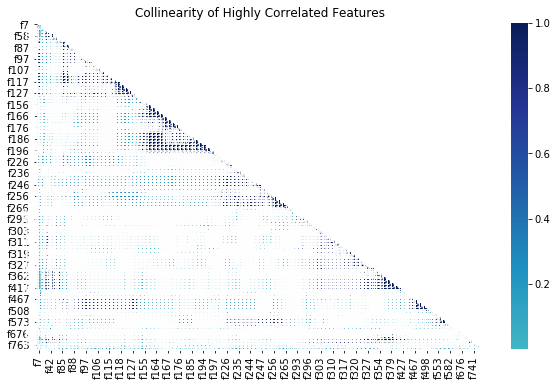

In [7]:
heatmap_of_correlation(cor_pearson, 0.99999999998)

In [59]:
def pca_computation(df, target_col):
    """
    Given dataset and target variable, plots 2d and 3d graphs for
    the first 2 or 3 reduced features respectively.
    The lighter colors correspond to the positive points.
    """
    
    # Normalize features
    features_df = df.drop(columns=[target_col])
    scaled_data = StandardScaler().fit_transform(features_df)
    
    # Get reduced features
    pca_res = pd.DataFrame()
    pca = PCA(n_components=100)
    pca_result = pca.fit_transform(scaled_data)
    pca_res['pca-one'] = pca_result[:,0]
    pca_res['pca-two'] = pca_result[:,1] 
    pca_res['pca-three'] = pca_result[:,2]
    pca_res["y"] = np.clip(df[target_col], 0, 1)
    print("Explained variation per principal component:", pca.explained_variance_ratio_.sum(), pca.n_components)

    # Plot 2-d graphs of 1st and 2nd components
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    ax.scatter(pca_res['pca-one'], 
               pca_res['pca-two'], 
               s = 50, c=pca_res['y'])
    ax.grid()
    plt.show()
    
    # Plot 3-d graphs of 1st to 3rd components
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=pca_res.loc[:]["pca-one"], 
        ys=pca_res.loc[:]["pca-two"], 
        zs=pca_res.loc[:]["pca-three"], 
        c=pca_res.loc[:]["y"], 
        cmap='tab10'
    )
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    ax.set_zlabel('pca-three')
    plt.show()

Explained variation per principal component: 0.8234021592750568 100


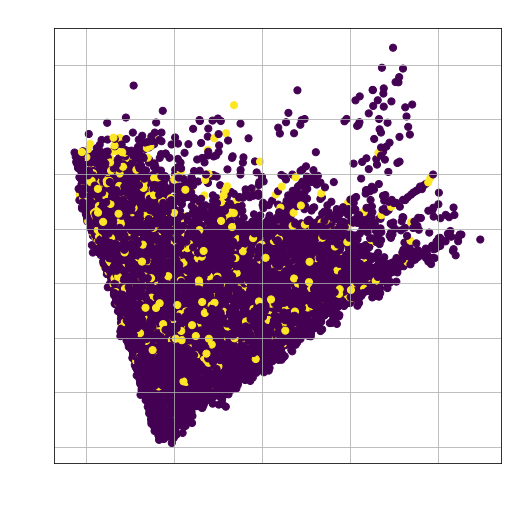

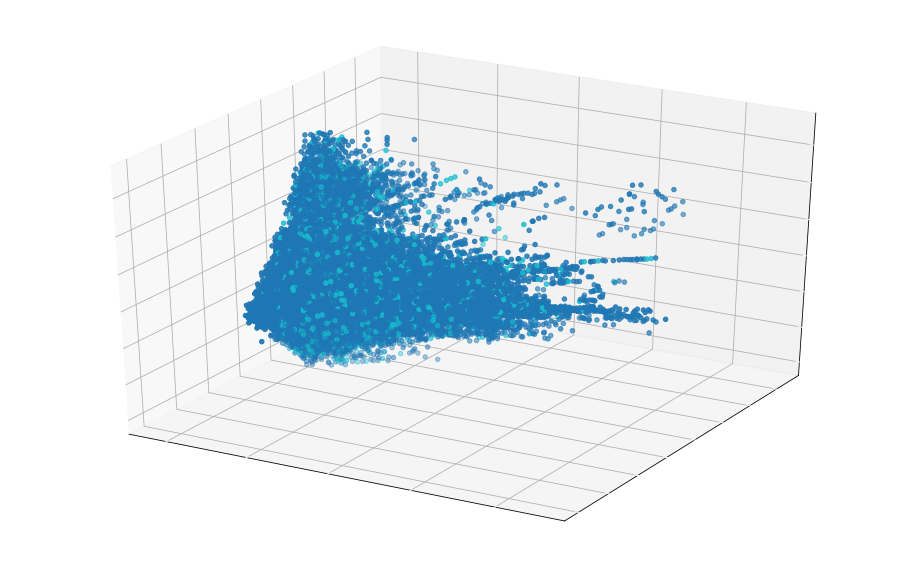

In [39]:
pca_computation(dropped_data, "loss")

# Data Modeling

### Note: This has changed to a classification problem

1. Random Forest/ Decision Tree

2. Support Vector Machine

3. K-NN Classifier

4. Linear Regression

5. Kernel Approximation

6. Stochastic Gradient Descent

### Previous Models

1. XG Boost Regressor

2. Random Forest Regressor

In [26]:
import matplotlib as mpl
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [195]:
def clip_modified(vector, threshold=None):
    """
    Binarizes a numpy array based on a threshold.
    """
    vec_copy = vector.copy()
    if threshold is None:
        vec_copy[vec_copy > 0] = 1
        vec_copy[vec_copy <= 0] = 0
    else:
        vec_copy[vec_copy >= threshold] = 1
        vec_copy[vec_copy < threshold] = 0
    return vec_copy

def get_best_features(X, num_features):
    """
    Reduce features to num_features
    """
    print("Starting PCA computation...")
    pca = PCA(n_components=num_features)
    pca_result = pca.fit_transform(X)
    print("Explained Variance:", pca.explained_variance_ratio_.sum())
    return pca_result

def down_sample(X, y):
    """
    Down sample data to have equal numbers of 
    positive and negative target variables.
    """
    print("Starting down sampling...")
    y.reset_index(drop=True, inplace=True)
    count = y.sum()
    indices0 = np.where(y == 0.0)[0]
    samples0 = random.choices(indices0, k=int(count))
    samples1 = list(np.where(y > 0)[0])
    samples0.extend(samples1)
    return X[samples0], y.iloc[samples0]

def prep_modeling(df, target):
    """
    Given dataframe and name of target column
    Creates a training, testing and validation set
    with ratios 4:3:3.
    Clips the target variable to binary.
    """
    print("Starting data splitting...")
    X = df.drop(columns=[target])
    y = df[target]
    X = StandardScaler().fit_transform(X)
    Xtrain, Xtest = train_test_split(X, test_size=0.6, shuffle=True)
    Xtest, Xval = train_test_split(Xtest, test_size=0.5, shuffle=True)
    ytrain, ytest = train_test_split(y, test_size=0.6, shuffle=True)
    ytest, yval = train_test_split(ytest, test_size=0.5, shuffle=True)
    return Xtrain, Xtest, Xval, ytrain, ytest, yval

def check_predictions(ypred, yset, oob=False):
    """
    Check distribution and MAE score of the predicted
    values given by model on the test set.
    """
    print("MAE: ", mean_absolute_error(yset, ypred))
    
    binary_test = yset.copy()
    binary_test[binary_test > 0] = 1
    binary_pred = ypred.copy()
    binary_pred[binary_pred > 0] = 1
    print(classification_report(binary_test, binary_pred))

    plt.hist(ypred, bins=range(101))
    plt.yscale("log")
    plt.title('Histogram of Predicted loss (log scale)')
    plt.show()

    plt.hist(yset, bins=range(101))
    plt.yscale("log")
    plt.title('Histogram of Actual loss (log scale)')
    plt.show()

from sklearn.tree import DecisionTreeRegressor
def create_and_fit_model(model_type, X, y, classification=False):
    """
    Create models based on model_type and fit
    to the training data given. Returns the model.
    """
    y_use = y.copy()
    if classification:
        y_use[y_use > 0] = 1
    clf = None
    if model_type == 0:
        clf = RandomForestClassifier(verbose=1) # Rand Forest
    elif model_type == 1:
        clf = DecisionTreeClassifier(max_depth=20, criterion="entropy")
    elif model_type == 2:
        clf = SVC(gamma='auto') # SVC
    elif model_type == 3:
        clf = KNeighborsClassifier(n_neighbors=2) # KNN
    elif model_type == 4:
        clf = LogisticRegression(penalty='l2') # Lin Reg
    elif model_type == 6:
        clf = SGDClassifier()  # SGD
    elif model_type == 7:
        clf = GradientBoostingClassifier(n_estimators=450, verbose=1)
    elif model_type == 8:
        clf = RandomForestRegressor()
    elif model_type == 9:
        clf = DecisionTreeRegressor()
    
    if clf is not None:
        clf.fit(X, y_use)
        
    return clf

def create_combined_model(clf_type, regr_type, X, y, Xe, ye):
    """
    Create models based on model_type and fit
    to the training data given. Returns the model.
    """
    y_use = y.copy()
    y_use[y_use > 0] = 1
    
    Xr = X[y >0]
    yr = y[y>0]
    
    Xer = Xe[ye >0]
    yer = ye[ye>0]
    
    ts = time.time() 
    
    clf = None
    model = None
    
    if clf_type == 0:
        clf = IsolationForest(contamination=0.1, behaviour="new").fit(X)
    elif clf_type == 1:
        clf = KNeighborsClassifier(n_neighbors=2)
        clf.fit(X, y_use)
    elif clf_type == 2:
        clf = DecisionTreeClassifier()
        clf.fit(X, y_use)
    
    if regr_type == 0:

        model = XGBRegressor(
            max_depth=10,
            n_estimators=1000,
            min_child_weight=0.5, 
            colsample_bytree=0.8, 
            subsample=0.8, 
            eta=0.01,
            seed=42)

        model.fit(
            Xr, 
            yr, 
            eval_metric="mae", 
            eval_set=[(Xr, yr), (Xer, yer)], 
            verbose=True, 
            early_stopping_rounds = 20)
        
    elif regr_type == 1:
        model = DecisionTreeClassifier(max_depth=20, criterion="entropy")
        model.fit(Xr, yr)
    elif regr_type == 2:
        model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1, 
                                       max_features=None, max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, min_impurity_split=None, 
                                       min_samples_leaf=1, min_samples_split=2, 
                                       min_weight_fraction_leaf=0.0, presort=False, 
                                       random_state=None, splitter='best')

        model.fit(Xr, yr)
    
    print("Training time:", time.time() - ts)
        
    return clf, model

def hyperparameter_tuning(model, X, y):
    
    parameters = {'criterion': ["mae"], 
                  'max_depth': range(1, 10), 
                  'min_samples_leaf' : range(1, 5)
                 }
    grid = GridSearchCV(model, parameters)
    grid.fit(X, y)
    return grid

def predict_on_model(models, X, num_models=1):
    """
    Create models based on model_type and fit
    to the training data given. Returns the model.
    """
    if num_models == 2:
        ypred1 = models[0].predict(X)
        ypred1[ypred1 > 0] = 0
        ypred1[ypred1 < 0] = 1
        interval = ypred1.copy()
        X_filtered = X[ypred1 > 0]
        ypred2 = models[1].predict(X_filtered).astype(int)
        ypred1[ypred1 > 0] = ypred2
        return ypred1, interval
    else:
        ypred = models.predict(X)
        return ypred
        


In [151]:
dropped_data["loss"] = data["loss"]
Xtrain, Xtest, Xval, ytrain, ytest, yval = prep_modeling(dropped_data, "loss")
bytrain = clip_modified(ytrain)
bytest = clip_modified(ytest)
Xtrain_down, ytrain_down = down_sample(Xtrain, ytrain)
Xtest_down, ytest_down = down_sample(Xtest, ytest)
Xval_down, yval_down = down_sample(Xval, yval)

Starting data splitting...
Starting down sampling...
Starting down sampling...
Starting down sampling...



Random Forest Model
[[27627  1063]
 [ 2845   106]]
MAE:  0.829588192535002
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     28690
           1       0.09      0.04      0.05      2951

    accuracy                           0.88     31641
   macro avg       0.50      0.50      0.49     31641
weighted avg       0.83      0.88      0.85     31641



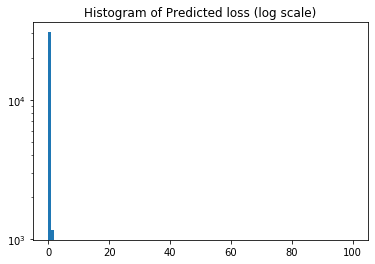

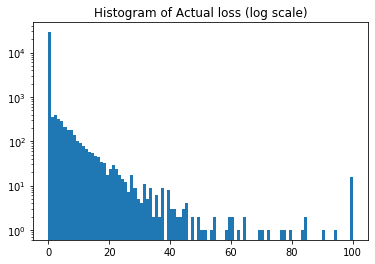


Decision Tree Model
[[28511   179]
 [ 2938    13]]
MAE:  0.8045889826490945
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     28690
           1       0.07      0.00      0.01      2951

    accuracy                           0.90     31641
   macro avg       0.49      0.50      0.48     31641
weighted avg       0.83      0.90      0.86     31641



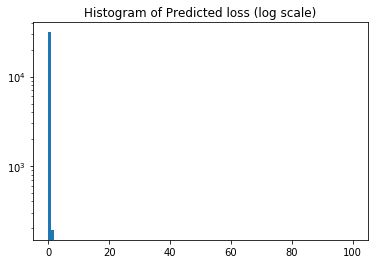

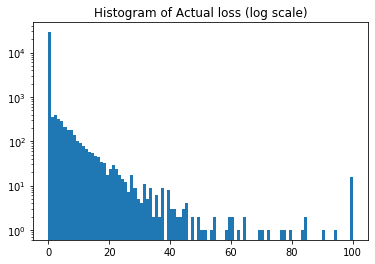


Logistic Regression Model
[[28676    14]
 [ 2951     0]]
MAE:  0.7997850889668469
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     28690
           1       0.00      0.00      0.00      2951

    accuracy                           0.91     31641
   macro avg       0.45      0.50      0.48     31641
weighted avg       0.82      0.91      0.86     31641



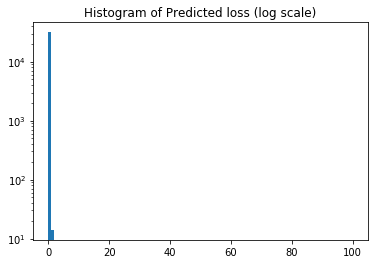

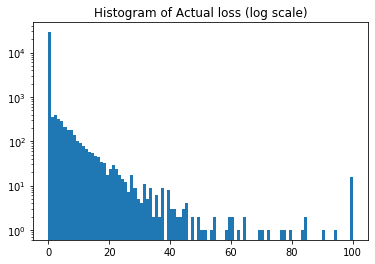


Gradient Boost Model
[[28640    50]
 [ 2947     4]]
MAE:  0.8007964350052148
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     28690
           1       0.07      0.00      0.00      2951

    accuracy                           0.91     31641
   macro avg       0.49      0.50      0.48     31641
weighted avg       0.83      0.91      0.86     31641



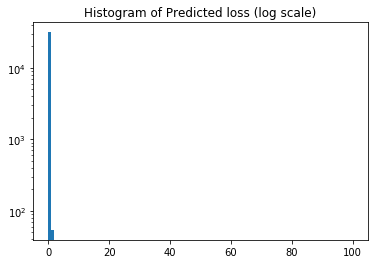

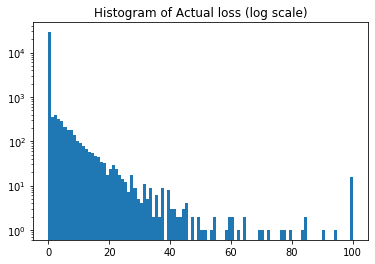

In [152]:
print("\nRandom Forest Model")
# model2 = create_and_fit_model(0, Xtrain, ytrain, classification=True)
# ypred2 = predict_on_model(model2, Xtest)
print(confusion_matrix(bytest, ypred2))
check_predictions(ypred2, ytest)

print("\nDecision Tree Model")
# model1 = create_and_fit_model(1, Xtrain, ytrain, classification=True)
# ypred1 = predict_on_model(model1, Xtest)
print(confusion_matrix(bytest, ypred1))
check_predictions(ypred1, ytest)

print("\nLogistic Regression Model")
# model5 = create_and_fit_model(4, Xtrain, ytrain, classification=True)
# ypred5 = predict_on_model(model5, Xtest)
print(confusion_matrix(bytest, ypred5))
check_predictions(ypred5, ytest)

print("\nGradient Boost Model")
# model7 = create_and_fit_model(7, Xtrain, ytrain, classification=True)
# ypred7 = predict_on_model(model7, Xtest)
print(confusion_matrix(bytest, ypred7))
check_predictions(ypred7, ytest)


In [160]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=275, max_depth=22, min_samples_split=2, 
                           max_features="sqrt", n_jobs=10, random_state=42, criterion="mae", verbose=1)
rf.fit(Xtrain, ytrain)
y_pred_rfr = rf.predict(Xtest)
print(confusion_matrix(bytest, clip_modified(y_pred_rfr)))
check_predictions(y_pred_rfr, ytest)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


KeyboardInterrupt: 


Decision Tree Model B
[[25801  2889]
 [ 2679   272]]
MAE:  1.3026136974179072
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     28690
           1       0.09      0.09      0.09      2951

    accuracy                           0.82     31641
   macro avg       0.50      0.50      0.50     31641
weighted avg       0.83      0.82      0.83     31641



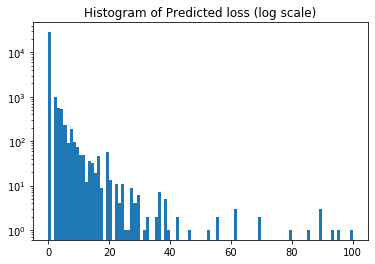

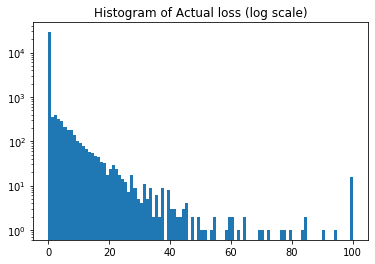


Decision Tree Model B
[[25447  3243]
 [ 2647   304]]
MAE:  1.3276129073038148
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     28690
           1       0.09      0.10      0.09      2951

    accuracy                           0.81     31641
   macro avg       0.50      0.49      0.49     31641
weighted avg       0.83      0.81      0.82     31641



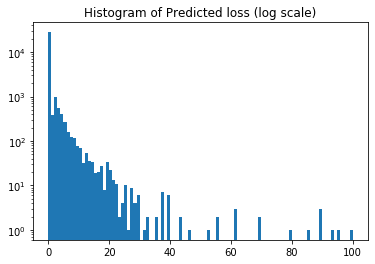

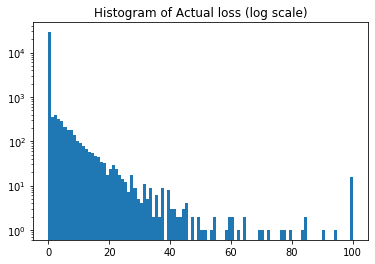

In [207]:
from scipy.special import inv_boxcox
from scipy.stats import boxcox

bc_ytrain, bc_ytrain_lambda = boxcox(ytrain+1.000001)

# print("\nRandom Forest Model B")
# model2b = create_and_fit_model(8, Xtrain, bc_ytrain)
# ypred2b = predict_on_model(model2b, Xtest)
# check_predictions(ypred2b, bc_ytest)

print("\nDecision Tree Model B")
# model1b = create_and_fit_model(9, Xtrain, bc_ytrain)
# ypred1b = predict_on_model(model1b, Xtest)
fin_ypred1b = (inv_boxcox(ypred1b, bc_ytrain_lambda)-1.000001).astype(int)
print(confusion_matrix(bytest, clip_modified(fin_ypred1b)))
check_predictions(fin_ypred1b, ytest)

print("\nDecision Tree Model B")
# model1b = create_and_fit_model(9, Xtrain, bc_ytrain)
# ypred1b = predict_on_model(model1b, Xtest)
fin_ypred1b = (inv_boxcox(ypred1b, bc_ytrain_lambda)-1).astype(int)
print(confusion_matrix(bytest, clip_modified(fin_ypred1b)))
check_predictions(fin_ypred1b, ytest)

In [139]:
# "Learn" the mean from the training data
mean_train = np.mean(ytrain)

# Get predictions on the test set
baseline_predictions = np.ones(ytrain.shape) * mean_train
zero_predictions = np.zeros(ytrain.shape)

# Compute MAE
print("Training Set:")
mae_baseline = mean_absolute_error(ytrain, baseline_predictions)
print("Mean MAE is {:.2f}".format(mae_baseline))
mae_baseline = mean_absolute_error(ytrain, zero_predictions)
print("Zero MAE is {:.2f}".format(mae_baseline))

# Get predictions on the test set
baseline_predictions = np.ones(ytest.shape) * mean_train
zero_predictions = np.zeros(ytest.shape)

# Compute MAE
print("Testing Set:")
mae_baseline = mean_absolute_error(ytest, baseline_predictions)
print("Mean MAE is {:.2f}".format(mae_baseline))
mae_baseline = mean_absolute_error(ytest, zero_predictions)
print("Zero MAE is {:.2f}".format(mae_baseline))

# Get predictions on the test set
baseline_predictions = np.ones(yval.shape) * mean_train
zero_predictions = np.zeros(yval.shape)

# Compute MAE
print("Validation Set:")
mae_baseline = mean_absolute_error(yval, baseline_predictions)
print("Mean MAE is {:.2f}".format(mae_baseline))
mae_baseline = mean_absolute_error(yval, zero_predictions)
print("Zero MAE is {:.2f}".format(mae_baseline))

Training Set:
Mean MAE is 1.40
Zero MAE is 0.77
Testing Set:
Mean MAE is 1.41
Zero MAE is 0.78
Validation Set:
Mean MAE is 1.48
Zero MAE is 0.85


Decision Tree Model
MAE:  1.748048418191587


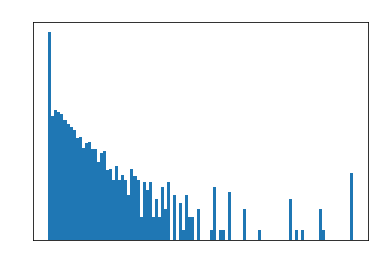

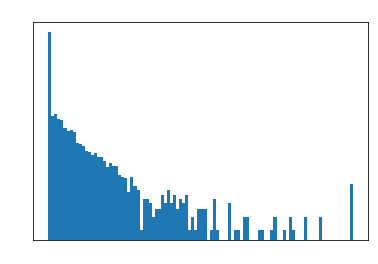


Random Forest Model
MAE:  0.8469074934420531


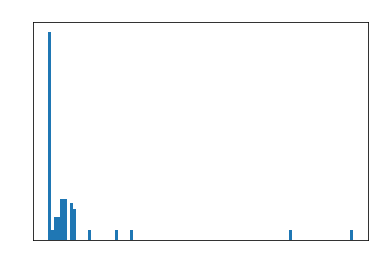

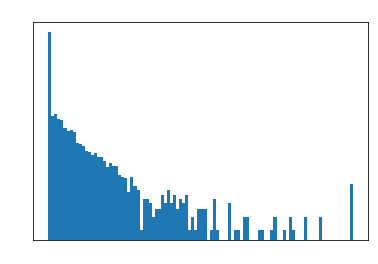


KNN Model
MAE:  0.8366992193672766


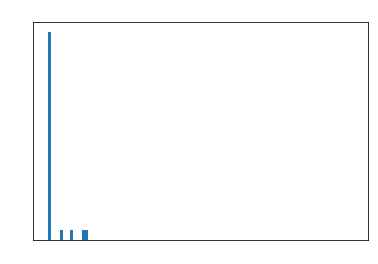

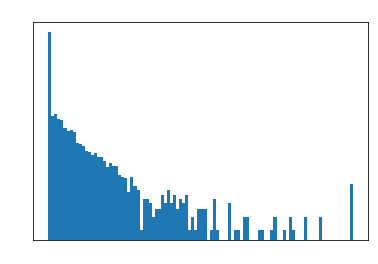


Logistic Regression Model
MAE:  0.8524698966530767


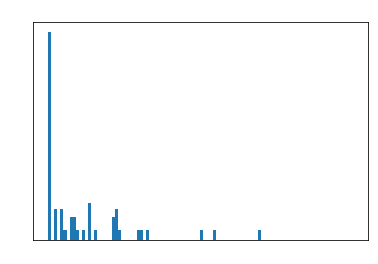

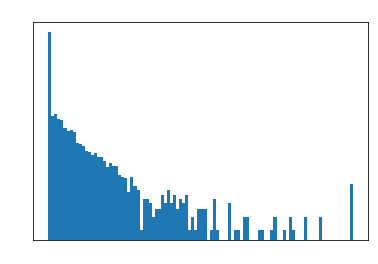


Support Vector Model
MAE:  0.8358775007111027


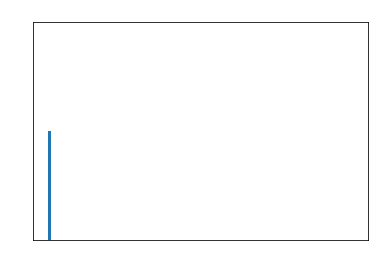

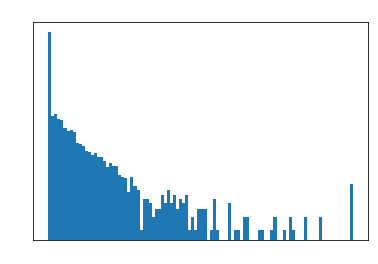


Stochastic Gradient Descent
MAE:  0.9074934420530325


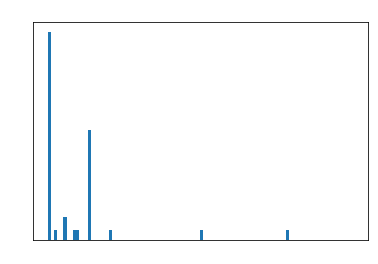

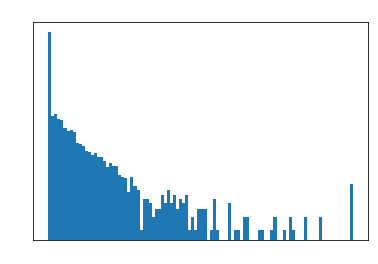

In [30]:
print("Decision Tree Model")
model1 = create_and_fit_model(1, Xtrain, ytrain)
ypred1 = predict_on_model(model1, Xtest)
check_predictions(ypred1, ytest)

print("\nRandom Forest Model")
model2 = create_and_fit_model(0, Xtrain, ytrain)
ypred2 = predict_on_model(model2, Xtest)
check_predictions(ypred2, ytest)

print("\nKNN Model")
model4 = create_and_fit_model(3, Xtrain, ytrain)
ypred4 = predict_on_model(model4, Xtest)
check_predictions(ypred4, ytest)

print("\nLogistic Regression Model")
model5 = create_and_fit_model(4, Xtrain, ytrain)
ypred5 = predict_on_model(model5, Xtest)
check_predictions(ypred5, ytest)

print("\nSupport Vector Model")
model3 = create_and_fit_model(2, Xtrain, ytrain)
ypred3 = predict_on_model(model3, Xtest)
check_predictions(ypred3, ytest)

print("\nStochastic Gradient Descent")
model6 = create_and_fit_model(6, Xtrain, ytrain)
ypred6 = predict_on_model(model6, Xtest)
check_predictions(ypred6, ytest)

[0]	validation_0-mae:8.15166	validation_1-mae:8.17449
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:8.07126	validation_1-mae:8.09295
[2]	validation_0-mae:7.99418	validation_1-mae:8.01548
[3]	validation_0-mae:7.91602	validation_1-mae:7.93804
[4]	validation_0-mae:7.84134	validation_1-mae:7.86487
[5]	validation_0-mae:7.76854	validation_1-mae:7.79406
[6]	validation_0-mae:7.69587	validation_1-mae:7.72564
[7]	validation_0-mae:7.63195	validation_1-mae:7.66459
[8]	validation_0-mae:7.57279	validation_1-mae:7.60723
[9]	validation_0-mae:7.51468	validation_1-mae:7.55125
[10]	validation_0-mae:7.45764	validation_1-mae:7.49724
[11]	validation_0-mae:7.40191	validation_1-mae:7.44460
[12]	validation_0-mae:7.34617	validation_1-mae:7.39341
[13]	validation_0-mae:7.28911	validation_1-mae:7.33987
[14]	validation_0-mae:7.23381	validation_1-mae:7.28839
[15]	validation_0-mae:7.1785

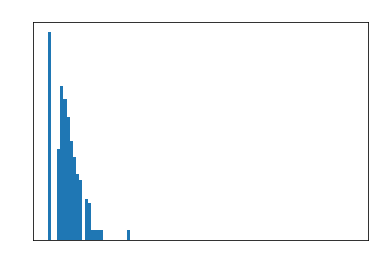

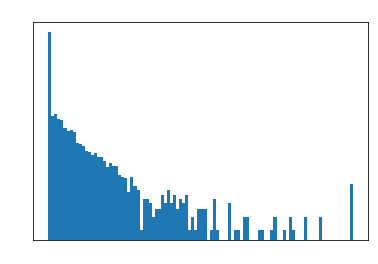

0.8210233557725736 0.8277806630321133


In [96]:
models1 = create_combined_model(0, 0, Xtrain, ytrain, Xtest, ytest)
ypred01, mid01 = predict_on_model(models1, Xtest, num_models=2)
check_predictions(ypred01, ytest)

In [ ]:
models1 = create_combined_model(0, 0, Xtrain, ytrain, Xtest, ytest)
ypred01, mid01 = predict_on_model(models1, Xtest, num_models=2)
check_predictions(ypred01, ytest)

In [ ]:
models2 = create_combined_model(0, 1, Xtrain, ytrain, Xtest, ytest)
ypred02, mid02 = predict_on_model(models2, Xtest, num_models=2)
check_predictions(ypred02, ytest)

In [ ]:
models3 = create_combined_model(0, 2, Xtrain, ytrain, Xtest, ytest)
ypred03, mid03 = predict_on_model(models3, Xtest, num_models=2)
check_predictions(ypred03, ytest)

In [ ]:
models4 = create_combined_model(0, 1, Xtrain, ytrain, Xtest, ytest)
ypred04, mid04 = predict_on_model(models4, Xtest, num_models=2)
check_predictions(ypred04, ytest)

In [ ]:
models5 = create_combined_model(2, 1, Xtrain, ytrain, Xtest, ytest)
ypred05, mid05 = predict_on_model(models5, Xtest, num_models=2)
check_predictions(ypred05, ytest)

[0]	validation_0-mae:8.07928	validation_1-mae:8.06532
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:8.00017	validation_1-mae:7.98641
[2]	validation_0-mae:7.92189	validation_1-mae:7.90781
[3]	validation_0-mae:7.84555	validation_1-mae:7.83200
[4]	validation_0-mae:7.76991	validation_1-mae:7.75540
[5]	validation_0-mae:7.69428	validation_1-mae:7.68054
[6]	validation_0-mae:7.62447	validation_1-mae:7.61354
[7]	validation_0-mae:7.56231	validation_1-mae:7.55407
[8]	validation_0-mae:7.50440	validation_1-mae:7.49676
[9]	validation_0-mae:7.44773	validation_1-mae:7.44153
[10]	validation_0-mae:7.39127	validation_1-mae:7.38610
[11]	validation_0-mae:7.33466	validation_1-mae:7.33178
[12]	validation_0-mae:7.28132	validation_1-mae:7.27879
[13]	validation_0-mae:7.22745	validation_1-mae:7.22566
[14]	validation_0-mae:7.17349	validation_1-mae:7.17436
[15]	validation_0-mae:7.1219

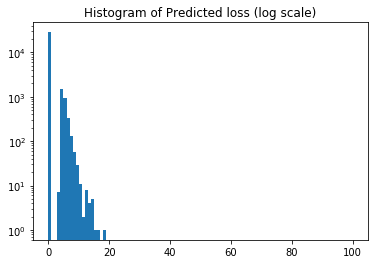

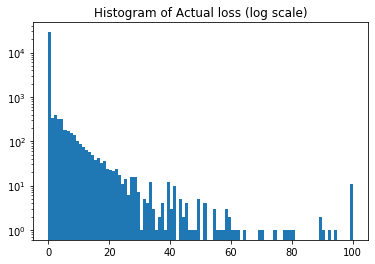

Training time: 37.08119201660156
MAE:  1.6972598843272968


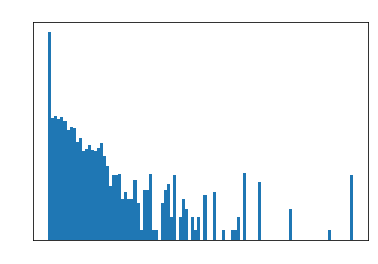

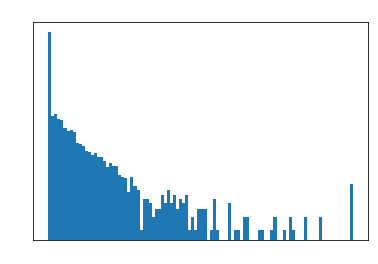

In [90]:
models2 = create_combined_model(0, 1, Xtrain, ytrain, Xtest, ytest)
ypred02, mid02 = predict_on_model(models2, Xtest, num_models=2)
check_predictions(ypred02, ytest)

Training time: 32.362916707992554
MAE:  1.0028128061692108


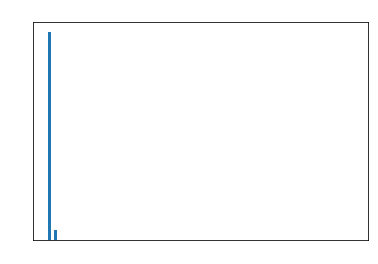

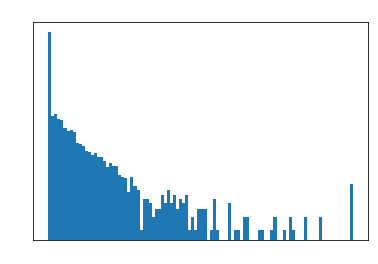

In [92]:
models3 = create_combined_model(0, 2, Xtrain, ytrain, Xtest, ytest)
ypred03, mid03 = predict_on_model(models3, Xtest, num_models=2)
check_predictions(ypred03, ytest)

Training time: 49.066776752471924
MAE:  1.25678708005436


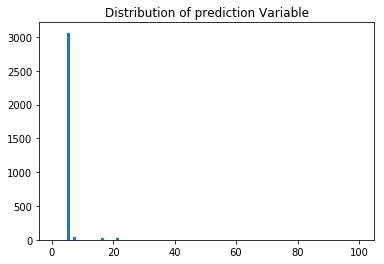

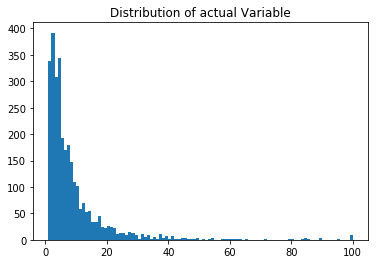

In [62]:
models4 = create_combined_model(0, 1, Xtrain, ytrain, Xtest, ytest)
ypred04, mid04 = predict_on_model(models4, Xtest, num_models=2)
check_predictions(ypred04, ytest)

Training time: 5.417405843734741
MAE:  1.7540532852943964


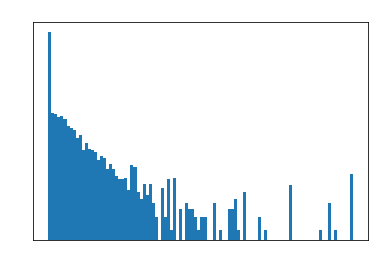

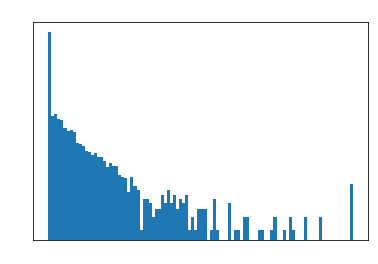

In [84]:
models5 = create_combined_model(2, 1, Xtrain, ytrain, Xtest, ytest)
ypred05, mid05 = predict_on_model(models5, Xtest, num_models=2)
check_predictions(ypred05, ytest)